# Mask vs No-Mask Classification using Transfer Learning

Due to the outbreak of COVID-19, the government has provided strict guidelines to use masks and stay safe. This project aims at building a deep learning solution to detect if someone has worn a mask or not. This will be useful in automated surveillance of the defaulters.

* Note : This project uses the dataset from Prajna Bhandary's github - https://github.com/prajnasb/observations.git

In [1]:
import os
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Download Prajna Bhandary's repository for dataset
! git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 1638 (delta 9), reused 0 (delta 0), pack-reused 1604
Receiving objects: 100% (1638/1638), 75.94 MiB | 32.60 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [3]:
# Where's the data ?
data_dir = 'observations/experiements/dest_folder'


In [4]:
# Define data transforms and preprocess the data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

In [5]:
# Create a data loader
train_loader = DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(image_datasets['test'], batch_size=32, shuffle=True, num_workers=4)

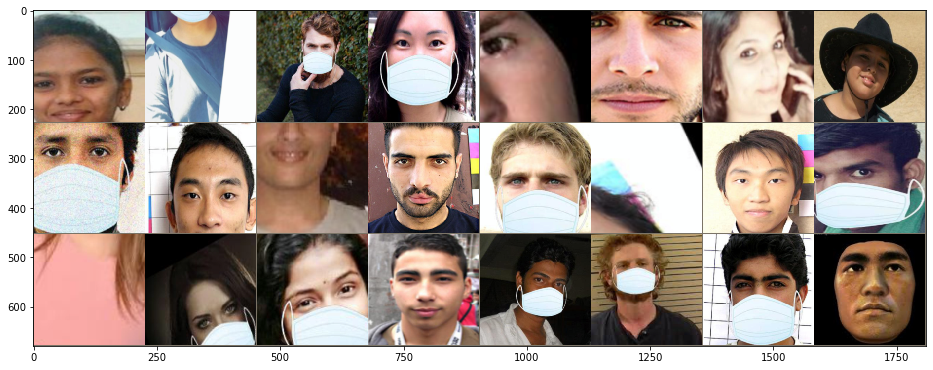

In [6]:
# Visualize the dataset
data_iter = iter(train_loader)
images, labels = data_iter.next() # sample one batch i.e, 32 samples
fig = plt.figure(figsize=(16, 24))
grid_imgs = torchvision.utils.make_grid(images[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
np_grid_imgs = np.transpose(np_grid_imgs, (1,2,0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
np_grid_imgs = std * np_grid_imgs + mean
np_grid_imgs = np.clip(np_grid_imgs, 0, 1)
plt.imshow(np_grid_imgs)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Download the pre-trained model 
model = torchvision.models.resnet18(pretrained=True)
# Display model
model


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Modify the classifier layer
in_features = model.fc.in_features
new_fc = nn.Sequential(
        nn.Linear(in_features, 200),
        nn.Linear(200, 2)
        )
model.fc = new_fc
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Hyperparameters
epochs = 2
lr = 1e-4

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

[Epoch 1/2] Iteration 1 -> Train Loss: 0.6898, Accuracy: 0.500
[Epoch 1/2] Iteration 2 -> Train Loss: 0.5499, Accuracy: 0.781
[Epoch 1/2] Iteration 3 -> Train Loss: 0.3935, Accuracy: 0.938
[Epoch 1/2] Iteration 4 -> Train Loss: 0.3582, Accuracy: 0.938
[Epoch 1/2] Iteration 5 -> Train Loss: 0.3071, Accuracy: 0.938
[Epoch 1/2] Iteration 6 -> Train Loss: 0.1790, Accuracy: 1.000
[Epoch 1/2] Iteration 7 -> Train Loss: 0.1516, Accuracy: 0.969
[Epoch 1/2] Iteration 8 -> Train Loss: 0.0910, Accuracy: 1.000
[Epoch 1/2] Iteration 9 -> Train Loss: 0.1038, Accuracy: 0.969
[Epoch 1/2] Iteration 10 -> Train Loss: 0.2212, Accuracy: 0.906
[Epoch 1/2] Iteration 11 -> Train Loss: 0.0747, Accuracy: 0.969
[Epoch 1/2] Iteration 12 -> Train Loss: 0.3239, Accuracy: 0.875
[Epoch 1/2] Iteration 13 -> Train Loss: 0.1328, Accuracy: 0.969
[Epoch 1/2] Iteration 14 -> Train Loss: 0.0766, Accuracy: 0.969
[Epoch 1/2] Iteration 15 -> Train Loss: 0.1824, Accuracy: 0.906
[Epoch 1/2] Iteration 16 -> Train Loss: 0.2606, A

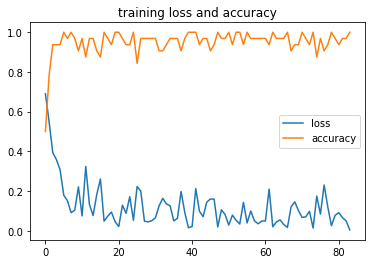

In [10]:
train_loss = 0
loss_list = []
acc_list = []
print_every = 1
counter = 1
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (counter % print_every == 0):
            predicted_labels = torch.argmax(preds, dim=1)
            corrects = predicted_labels.eq(labels)
            accuracy = torch.mean(corrects.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'\
                  .format(epoch+1, epochs, counter, train_loss/print_every, accuracy))
            loss_list.append(train_loss/print_every)
            acc_list.append(accuracy)
            train_loss = 0
        
        counter += 1   

# Plot the training history
plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [11]:
# Save weights
model_path = 'ckpt_resnet18_mask-vs-nomask.pth'
torch.save(model.state_dict(), model_path)

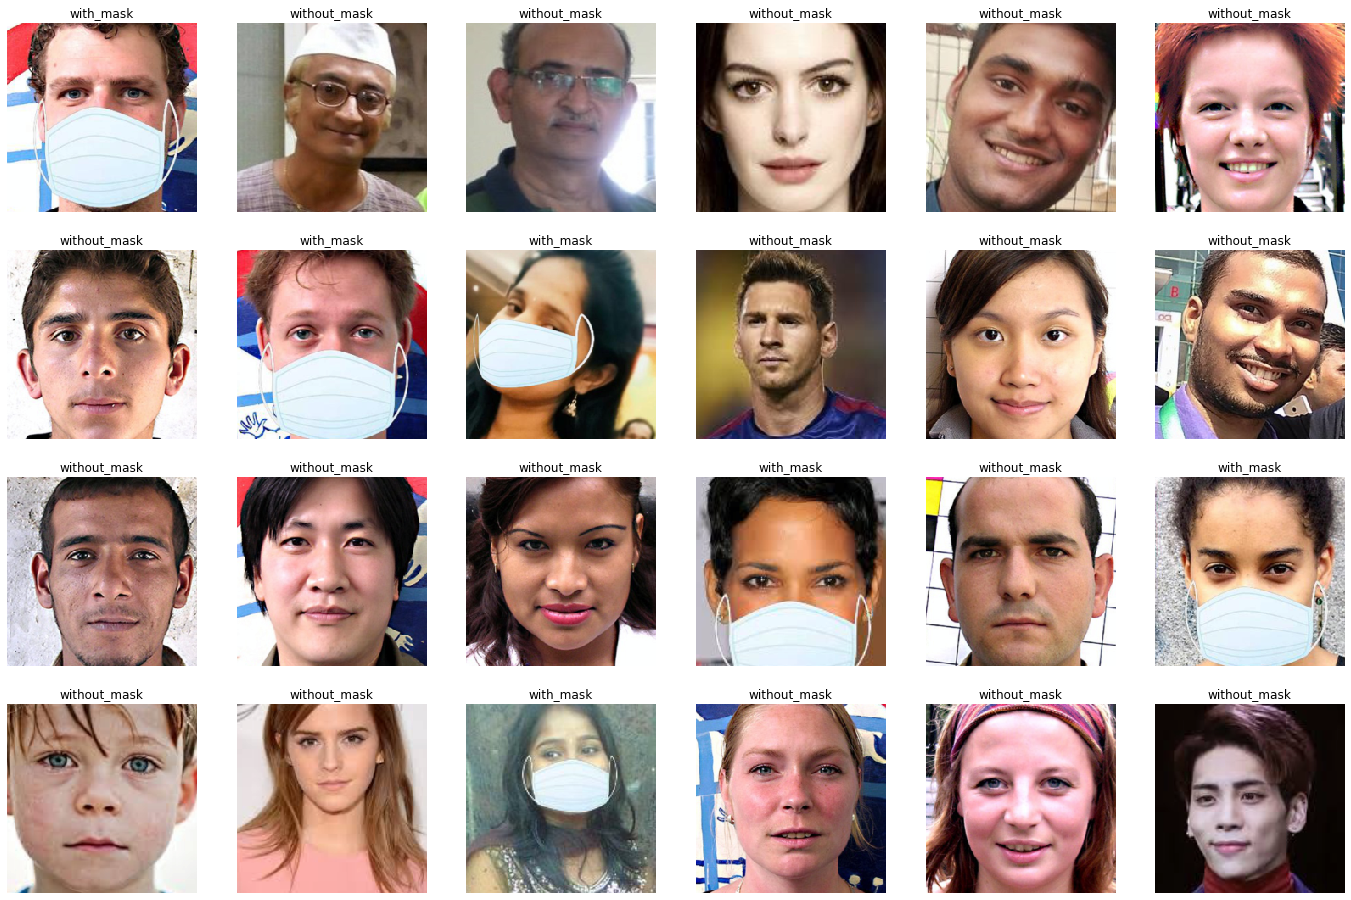

In [12]:
samples, _ = iter(test_loader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'with_mask', 1:'without_mask'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    sample = np.transpose(sample, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    sample = std * sample + mean
    sample = np.clip(sample, 0, 1)
    plt.imshow(sample)